<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [0]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant', 'MAMS', 'mpqa']
HUE_ORDER = ['STL', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (CD)', 
             'MTL (SFU)', 'MTL (SPEC)']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'


def create_quad_plot(data_df: pd.DataFrame) -> List[List[plt.Axes]]:
  fig, axes = plt.subplots(2,2,figsize=(15,10))
  dataset_list_order = [['Restaurant', 'MAMS'],['Laptop', 'mpqa']]
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for row_index, dataset_name_list in enumerate(dataset_list_order):
    for col_index, dataset_name in enumerate(dataset_name_list):
      df = data_df[data_df['Dataset']==dataset_name]
      axes[row_index][col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd',
                                                y='Score', hue='Model',
                                                x='Metric', data=df,
                                                hue_order=HUE_ORDER,
                                                order=METRIC_ORDER,
                                                ax=axes[row_index][col_index])
      axes[row_index][col_index].set_title(f'{dataset_name}')
      if row_index == 0:
        axes[row_index][col_index].set_xlabel('')
      if col_index == 1:
        axes[row_index][col_index].set_ylabel('')
      if row_index != 0 or col_index == 1:
        axes[row_index][col_index].get_legend().remove()
      else:
        axes[row_index][col_index].legend(ncol=7, borderaxespad=0.,
                                          bbox_to_anchor=(0.18, 1.1), 
                                          loc='lower left')
  return axes

def create_triple_plot(data_df: pd.DataFrame) -> List[plt.Axes]:
  fig, axes = plt.subplots(1,3,figsize=(22.5, 5))
  dataset_list_order = ['Restaurant', 'MAMS', 'Laptop']
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for col_index, dataset_name in enumerate(dataset_list_order):
    df = data_df[data_df['Dataset']==dataset_name]
    axes[col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd', y='Score', 
                                    hue='Model', x='Metric', data=df,
                                    hue_order=HUE_ORDER, order=METRIC_ORDER,
                                    ax=axes[col_index])
    axes[col_index].set_title(f'{dataset_name}')
    if col_index != 0:
      axes[col_index].set_ylabel('')
    if col_index != 0:
      axes[col_index].get_legend().remove()
    else:
      axes[col_index].legend(ncol=7, borderaxespad=0., 
                             bbox_to_anchor=(0.9, 1.1), loc='lower left')
  return axes

def get_data() -> Dict:
  results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
  model_names = ['STL', 'MTL (CD)', 'MTL (SFU)', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (SPEC)']
  dataset_names = ['mpqa', 'Restaurant', 'Laptop', 'MAMS']
  split_names = ['Validation', 'Test']
  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    elif model_name == 'MTL (CD)':
      model_url = base_url + '/mtl/conan_doyle'
    elif model_name == 'MTL (SFU)':
      model_url = base_url + '/mtl/sfu'
    elif model_name == 'MTL (UPOS)':
      model_url = base_url + '/mtl/u_pos'
    elif model_name == 'MTL (DR)':
      model_url = base_url + '/mtl/dr'
    elif model_name == 'MTL (LEX)':
      model_url = base_url + '/mtl/lextag'
    elif model_name == 'MTL (SPEC)':
      model_url = base_url + '/mtl/sfu_spec'
    elif model_name == 'MTL (LEX NEG)':
      model_url = base_url + '/mtl/cd_lextag'
    for dataset_name in dataset_names:
      for split_name in split_names:
        if split_name == 'Test':
          if dataset_name == 'MAMS':
            result_url = model_url + f'/{dataset_name}/test.conll'
          else:
            result_url = model_url + f'/{dataset_name.lower()}/test.conll'
        elif split_name == 'Validation':
          if dataset_name == 'MAMS':
            result_url = model_url + f'/{dataset_name}/dev.conll'
          else:
            result_url = model_url + f'/{dataset_name.lower()}/dev.conll'
        for run_number in range(5):
          with tempfile.TemporaryDirectory() as temp_dir:
            temp_fp = Path(temp_dir, 'temp_file.txt')
            with temp_fp.open('w') as temp_file:
              temp_file.write(requests.get(result_url).text)
            f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=True)
            f1_a_recall, f1_a_precision, f1_a = f1_a
            f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False)
            f1_i_recall, f1_i_precision, f1_i = f1_i
            pos_filter_name = 'POS'
            neu_filter_name = 'NEU'
            neg_filter_name = 'NEG'
            if dataset_name == 'mpqa':
              pos_filter_name = 'positive'
              neu_filter_name = 'neutral'
              neg_filter_name = 'negative'

            f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment=pos_filter_name)
            f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
            f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment=neu_filter_name)
            f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
            f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment=neg_filter_name) 
            f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
            f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                        metric_func=f1_score, 
                                                        average='macro')
            acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                        metric_func=accuracy_score)
            results_df_dict['Model'].append(model_name)
            results_df_dict['Dataset'].append(dataset_name)
            results_df_dict['Split'].append(split_name)
            results_df_dict['Run'].append(run_number)
            results_df_dict['F1-a'].append(f1_a)
            results_df_dict['F1-a-R'].append(f1_a_recall)
            results_df_dict['F1-a-P'].append(f1_a_precision)
            results_df_dict['F1-i'].append(f1_i)
            results_df_dict['F1-i-R'].append(f1_i_recall)
            results_df_dict['F1-i-P'].append(f1_i_precision)
            results_df_dict['F1-i-pos'].append(f1_i_pos)
            results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
            results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
            results_df_dict['F1-i-neg'].append(f1_i_neg)
            results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
            results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
            results_df_dict['F1-i-neu'].append(f1_i_neu)
            results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
            results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
            results_df_dict['F1-s'].append(f1_s)
            results_df_dict['Acc-s'].append(acc_s)
  return results_df_dict

# Significant Testing methods
from scipy import stats
def one_tailed_p_value(scores_1: List[float], scores_2: List[float], 
                       assume_normal: bool) -> float:
  '''
  :param scores_1: The scores e.g. list of accuracy values that reprsent one 
                    model/methods results (multiple scores can come from running 
                    the same model/method over different random seeds and/or 
                    dataset splits).
  :param scores_2: Same as `scores_1` but coming from a different method/model
  :param assume_normal: If the the scores are assumed to come from a normal 
                        distribution. See the following guide by 
                        `Dror and Reichart 2018 <https://arxiv.org/pdf/1809.01448.pdf>`_
                        to know if your metric/scores can be assumed to be normal or 
                        not. The test used when the scores are normal is the 
                        Welch’s t-test. When not normal it is the 
                        Wilcoxon signed-rank test.
  :returns: The p-value of a one-tailed test to determine if `scores_1` is 
            better than `scores_2`.
  '''
  p_value = -1.0
  if assume_normal:
    stat_result = stats.ttest_ind(scores_1, scores_2, equal_var=False, 
                                  nan_policy='raise')
    # one tailed hence why divided by 2
    p_value = stat_result.pvalue / 2
    # This is to take into account if the other is better
    if stat_result.statistic < 0:
      p_value = 1 - p_value
  else:
    stat_result = stats.wilcoxon(scores_1, scores_2, correction=False, 
                                  alternative='greater', zero_method='wilcox')
    p_value = stat_result.pvalue
  if p_value == -1.0:
    raise ValueError('P-Value was not calculated for these scores: '
                      f'score_1 {score_1} and scores_2 {scores_2} where '
                      f'the assumption of normality is {assume_normal}')
  return p_value

def create_p_value_results(metric_results: pd.DataFrame, 
                           p_value_threshold: float = 0.05
                           ) ->Dict[str, Dict[str, Dict[str, Dict[str, int]]]]:
  stats_metrics = metric_results['Metric'].unique().tolist()
  stats_datasets = metric_results['Dataset'].unique().tolist()
  stats_model_names = metric_results['Model'].unique().tolist()
  # Store whether or not one model is significantly better than another
  dataset_metric_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
  for dataset in stats_datasets:
    dataset_df = metric_results[metric_results['Dataset']==dataset]
    for metric in stats_metrics:
      metric_df = dataset_df[dataset_df['Metric']==metric]
      for model in stats_model_names:
        for compare_model in stats_model_names:
          if compare_model == model:
            dataset_metric_model_stats[dataset][metric][model][compare_model] = 0
          else:
            model_results = metric_df[metric_df['Model']==model]['Score'].tolist()
            compare_model_results = metric_df[metric_df['Model']==compare_model]['Score'].tolist()
            if metric == 'Acc-s':
              assume_normal = True
            else:
              assume_normal = False
            p_value = one_tailed_p_value(model_results, compare_model_results, 
                                        assume_normal=assume_normal)
            significant = 0
            if p_value <= p_value_threshold:
              significant = 1
            dataset_metric_model_stats[dataset][metric][model][compare_model] = significant
  return dataset_metric_model_stats
  
def create_stats_heatmap(stats_dict: Dict[str, Dict[str, Dict[str, Dict[str, int]]]],
                         metric: str) -> List[List[plt.Axes]]:
  cmap = sns.color_palette("RdBu_r", 7)
  dataset_list_order = [['Restaurant', 'MAMS'],['Laptop', 'mpqa']]
  fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)
  for row_index, dataset_list in enumerate(dataset_list_order):
    for col_index, dataset in enumerate(dataset_list):
      model_comparisons = stats_dict[dataset][metric]
      ax = axes[row_index][col_index]
      ax = sns.heatmap(pd.DataFrame(model_comparisons), cmap=cmap,linewidths=.5, 
                      ax=ax)
      ax.set_title(dataset)
  return axes

# Evaluating Targeted Sentiment Analysis (TSA) Systems
In this notebook we evaluate the different TSA models where each model is made up of the same general architecture which is similar to the model used in [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf). The architecture is two stacked Bi-LSTM's with a connection layer from the embedding to the second Bi-LSTM. The general learning objective is to improve the Span F1 measure on extracting the targets and their respective sentiment from the text. The models differ with respect to the task and data they learn from:

1. Baseline Single Task Learning (STL) model which uses only the given TSA data.
2. Multi Task Learning (MTL) model which learns negation scope and cue detection as an auxilary task, but the main task is TSA. 

The MTL models can learn from one of two data sources:
1. [Conan Doyle stories Morante and Blanco, 2012](https://www.aclweb.org/anthology/S12-1035.pdf) 
2. [SFU a review corpus Konstantinova et al. 2012](http://www.lrec-conf.org/proceedings/lrec2012/pdf/533_Paper.pdf) taken from Epinions.com where the review domains are:
  * Books
  * Cars
  * Computers
  * Cookware
  * Hotels
  * Movies
  * Music
  * Phones 

The TSA datasets that the models will be evaluated are the **Laptop** and **Restaurant** review datasets taken from [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf) which originally come from the SemEval [2014](https://www.aclweb.org/anthology/S14-2004/), [2015](https://www.aclweb.org/anthology/S15-2082/), and [2016](https://www.aclweb.org/anthology/S16-1002/) aspect based sentiment analysis task. We took the dataset from [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf) so that our results are directly comparable as their dataset statistics are different from the original datasets, which is most likely due to transforming the dataset into CONLL format which is token and not span based as the original datasets are. We are also going to use the **MAMS** restuarant datastes from [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654.pdf).

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

The main metric for TSA is *F1-i*. The other metrics will probe the models performance in the relevant areas to allow better understanding of these models.

Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Split
5. Metric
6. Score


In [7]:
results_df = pd.DataFrame(get_data())
not_metric_cols = ['Model', 'Dataset', 'Split', 'Run']
metric_cols = [col_name for col_name in results_df.columns.tolist() 
               if col_name not in not_metric_cols]
results_df = pd.melt(results_df, id_vars=not_metric_cols, value_vars=metric_cols, 
                     var_name='Metric', value_name='Score')
test_results_df = results_df[results_df['Split']=='Test']
val_results_df = results_df[results_df['Split']=='Validation']
results_df.head()

,Model,Dataset,Split,Run,Metric,Score
0,STL,mpqa,Validation,0,F1-a,0.159710
1,STL,mpqa,Validation,1,F1-a,0.215289
2,STL,mpqa,Validation,2,F1-a,0.197026
3,STL,mpqa,Validation,3,F1-a,0.202658
4,STL,mpqa,Validation,4,F1-a,0.230994


## F1-i

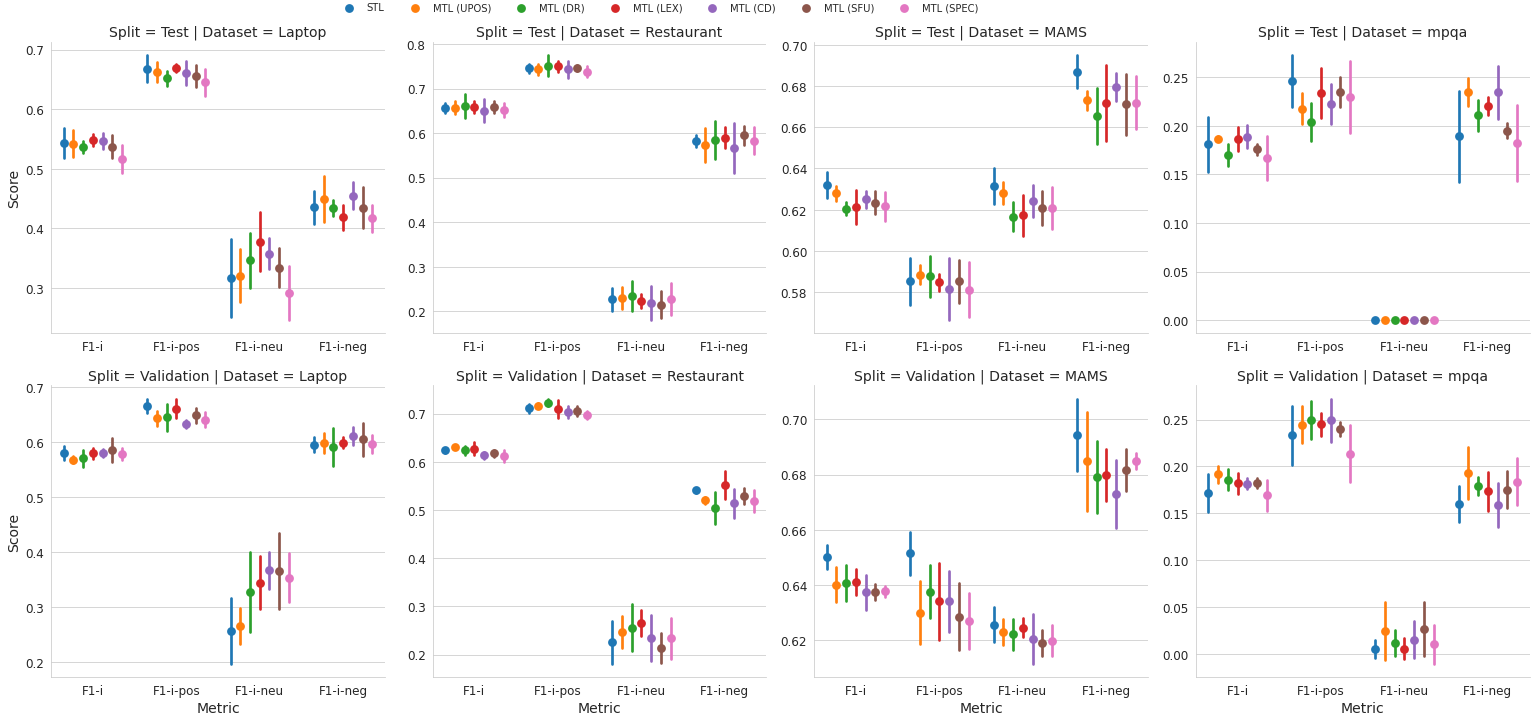

In [9]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = results_df[results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=results_df, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## F1-a

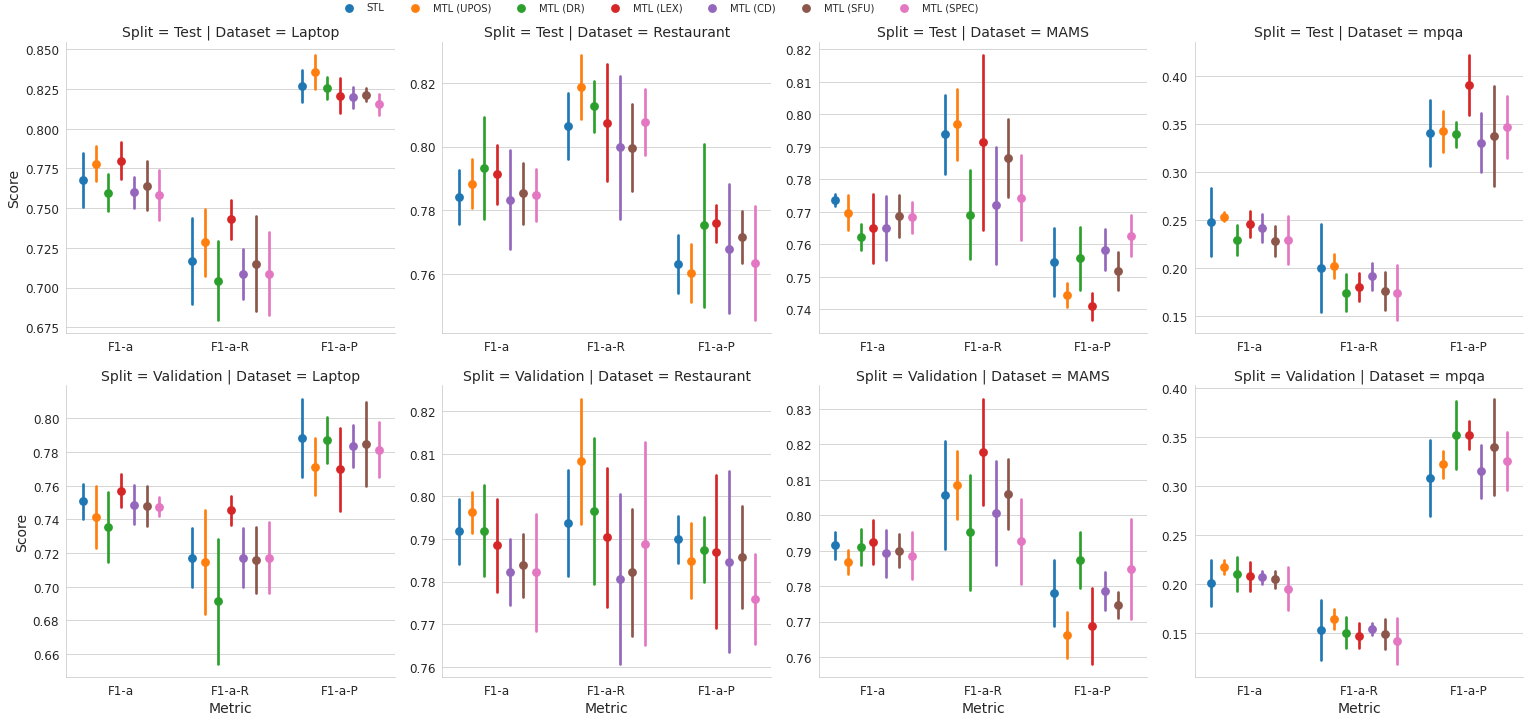

In [12]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = results_df[results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## F1-s and Acc-s

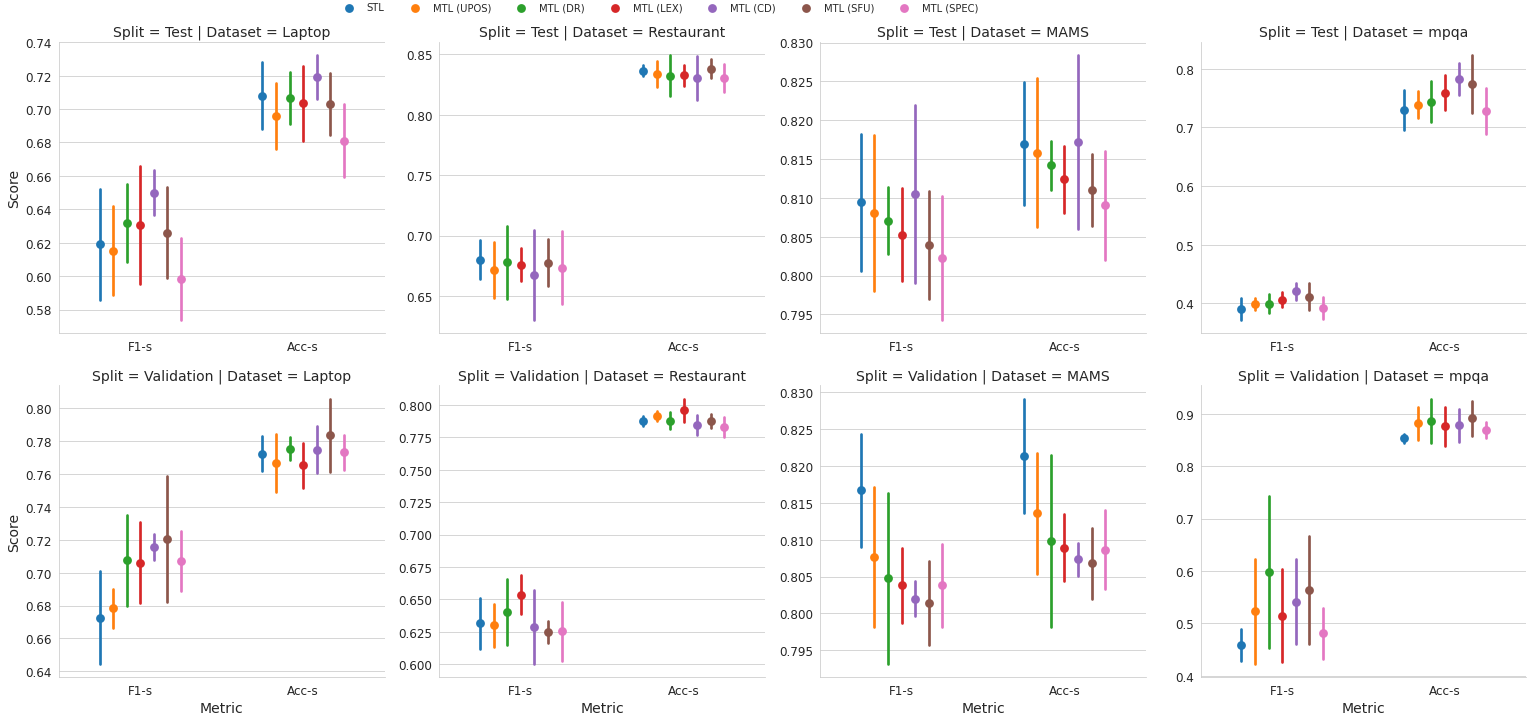

In [13]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = results_df[results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

To fit the graphs within the paper we also construct them individually for the test and validation results:

### Validation Results

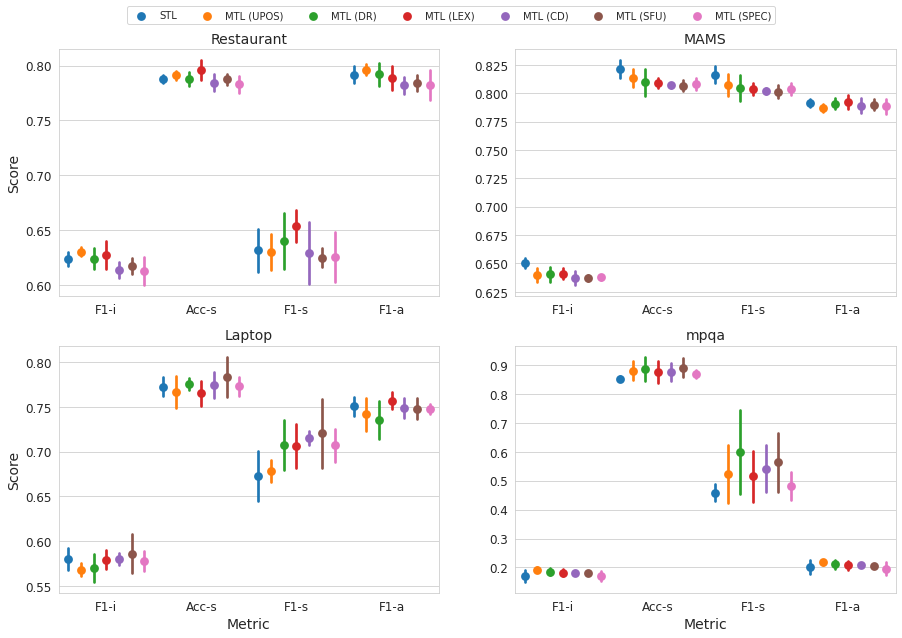

In [14]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = results_df[results_df['Metric'].isin(headline_metric_order)]
validation_headline_results = headline_results[headline_results['Split']=='Validation']
_ = create_quad_plot(validation_headline_results)

### Test Results

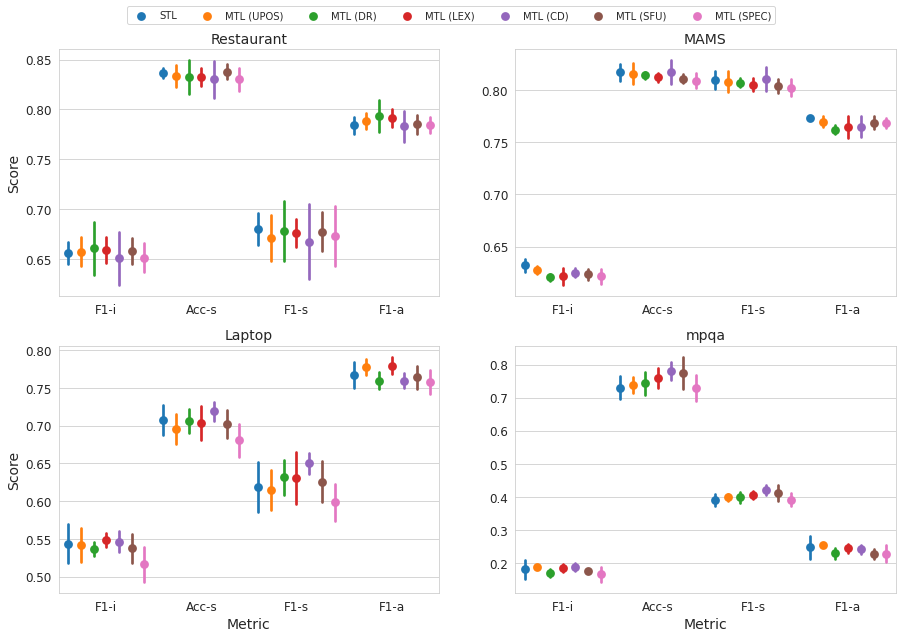

In [15]:
test_headline_results = headline_results[headline_results['Split']=='Test']
_ = create_quad_plot(test_headline_results)

### Statistical Tests

Given the headline metrics we want to find out which of the models are statistically significantly better than the others on each of the metrics. To do so we test each model against each other taking into account their random seeds.

The heatmaps show if the models on the X-axis are significantly better than those on the Y-axis. Where the P-value is 0.05 thus 95% confidence level.

#### F1-i

Validation:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


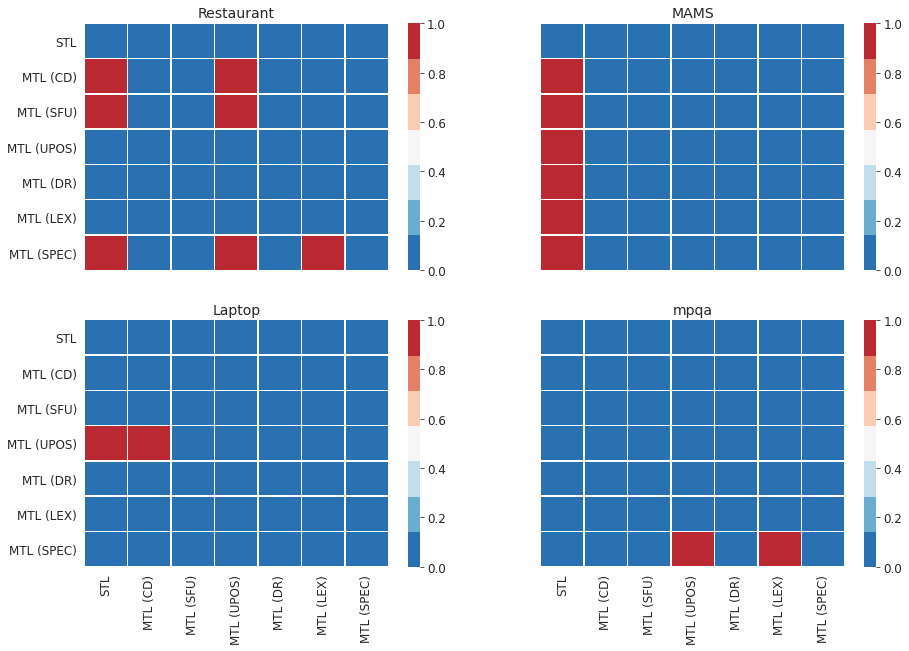

In [100]:
validation_p_value_results = create_p_value_results(validation_headline_results, p_value_threshold=0.05)
_ = create_stats_heatmap(validation_p_value_results, metric='F1-i')

Test:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


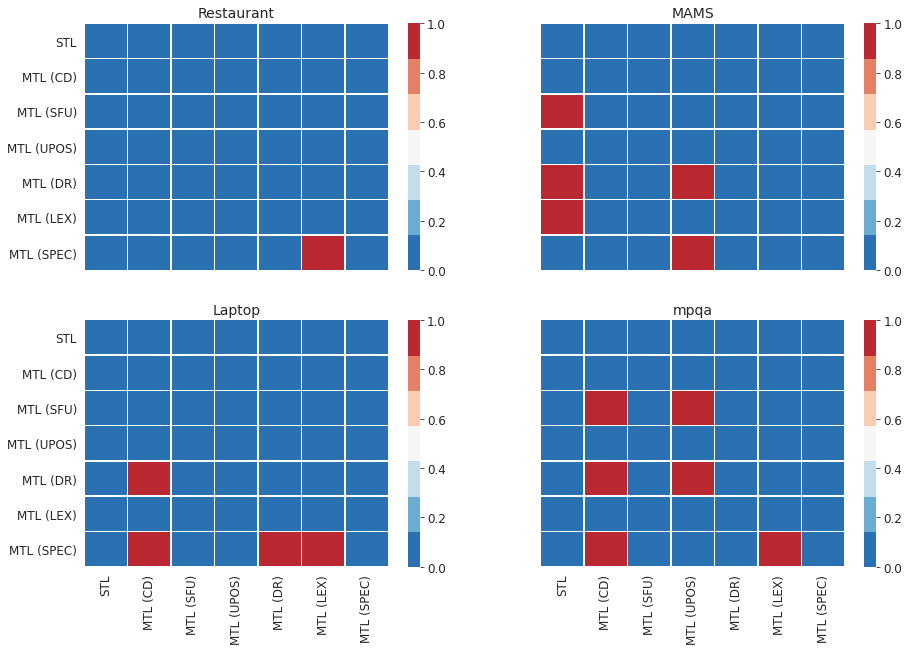

In [101]:
test_p_value_results = create_p_value_results(test_headline_results, p_value_threshold=0.05)
_ = create_stats_heatmap(test_p_value_results, metric='F1-i')

#### F1-a

Validation:

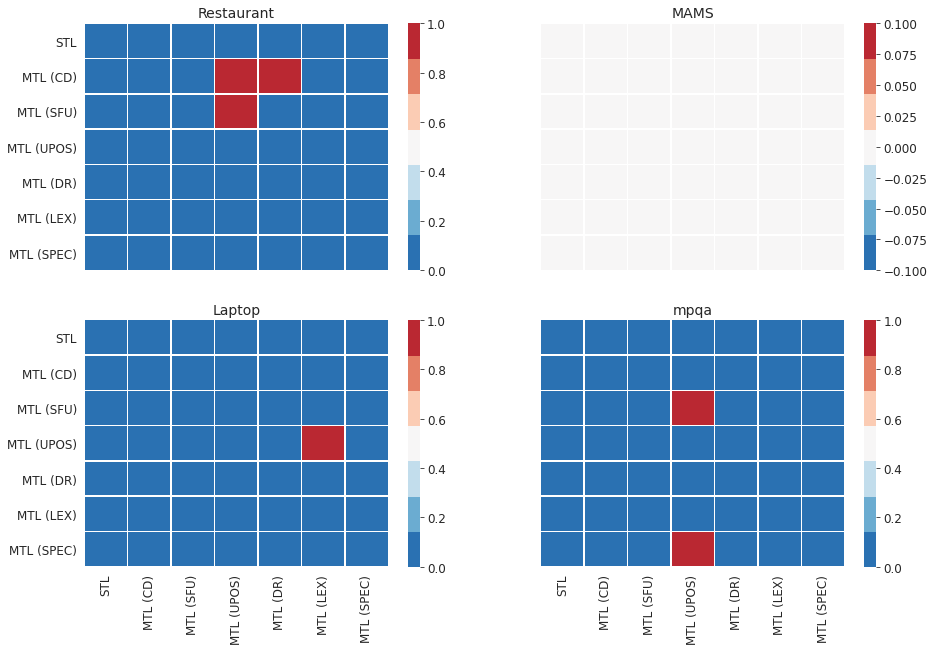

In [102]:
_ = create_stats_heatmap(validation_p_value_results, metric='F1-a')

Test:

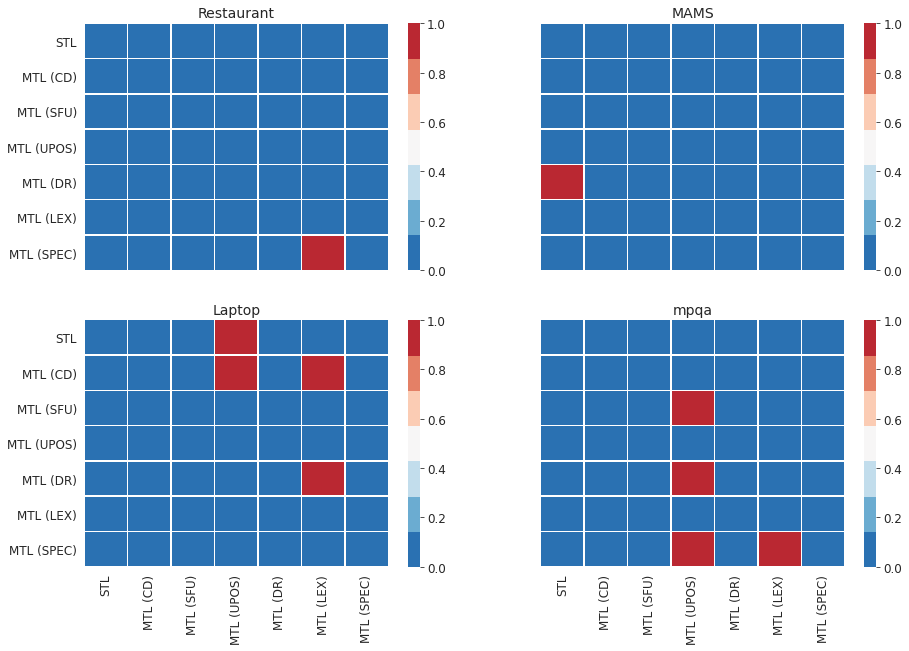

In [103]:
_ = create_stats_heatmap(test_p_value_results, metric='F1-a')

#### F1-s

Validation:

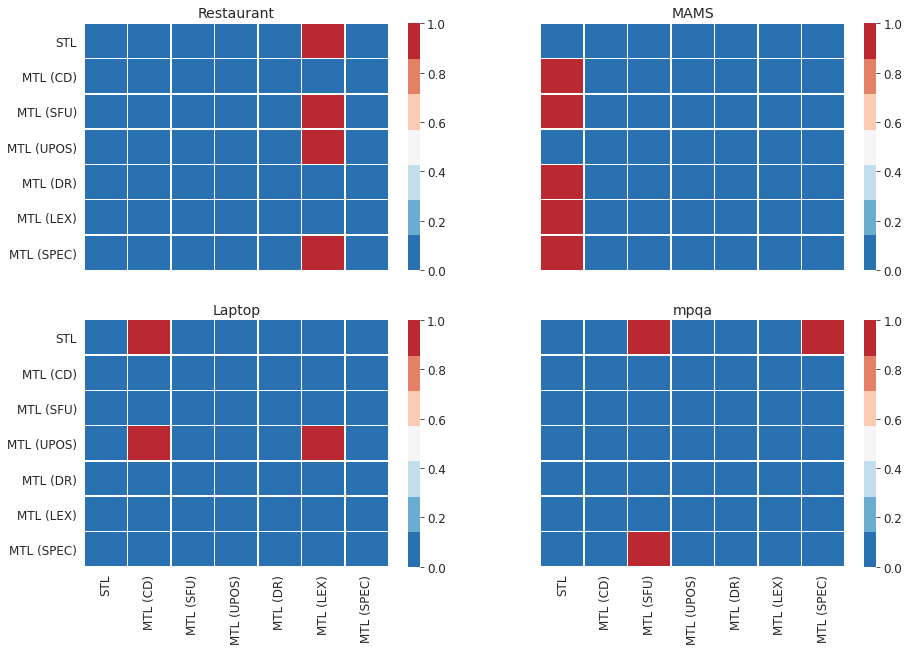

In [104]:
_ = create_stats_heatmap(validation_p_value_results, metric='F1-s')

Test:

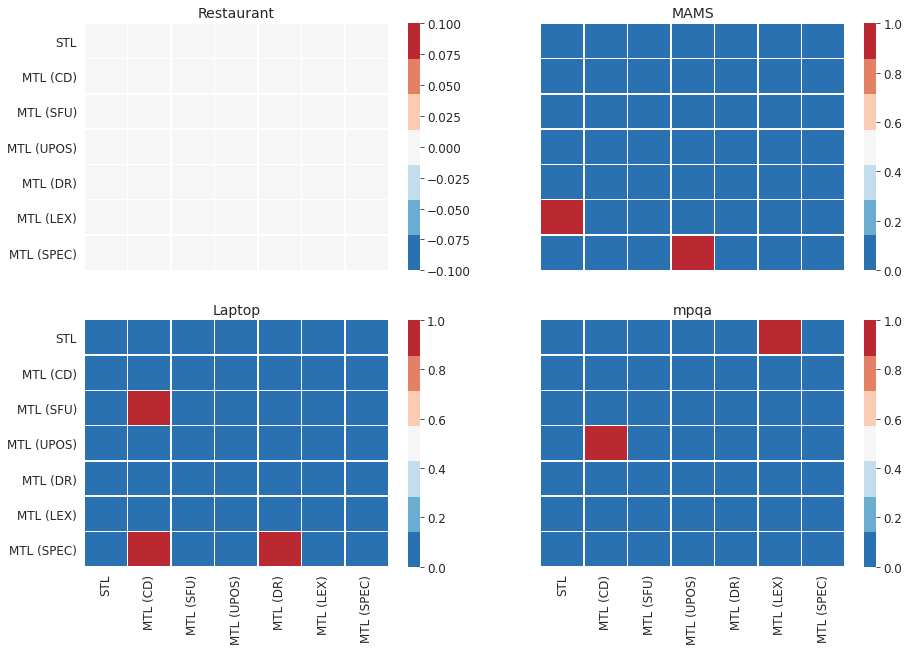

In [105]:
_ = create_stats_heatmap(test_p_value_results, metric='F1-s')

#### Acc-s

Validation:

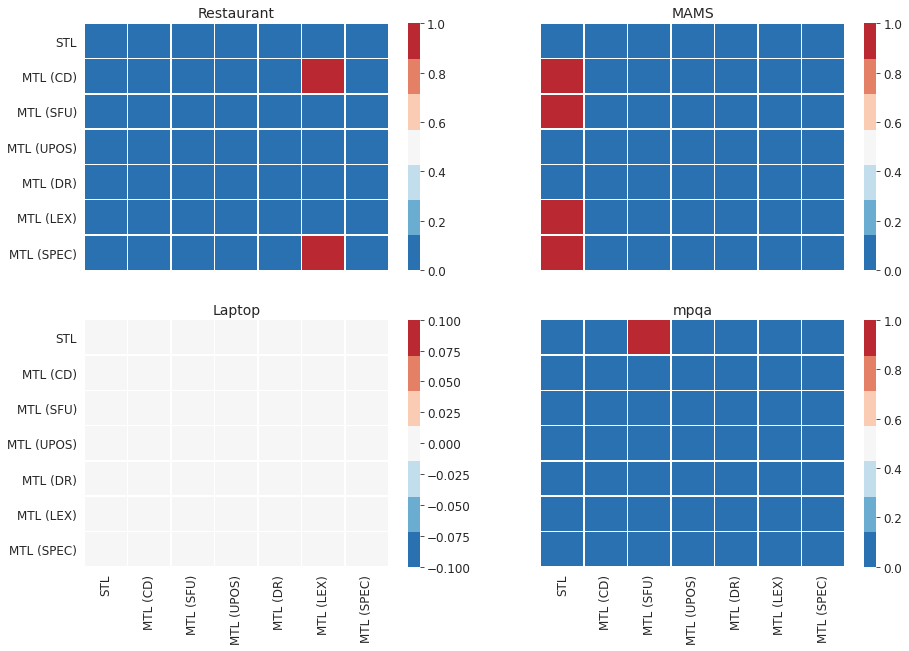

In [106]:
_ = create_stats_heatmap(validation_p_value_results, metric='Acc-s')

Test:

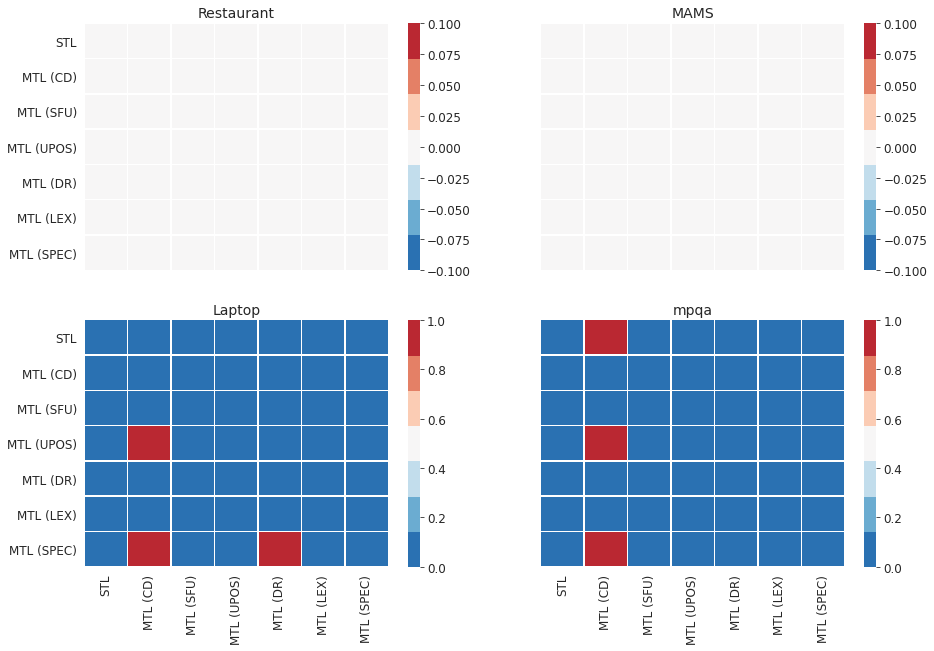

In [107]:
_ = create_stats_heatmap(test_p_value_results, metric='Acc-s')